# Loop 13 Analysis: Strategic Assessment

## Key Observations
1. 13 experiments have been run, all converging to ~70.66
2. Local optimization (SA, GA, bbox3) provides essentially 0 improvement
3. The baseline is at an EXTREMELY strong local optimum
4. Target is 68.919154 (gap of 1.74 points, 2.5%)

## Critical Question: What are top teams doing differently?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Current status
baseline_score = 70.659959
target_score = 68.919154
gap = baseline_score - target_score
gap_pct = (gap / baseline_score) * 100

print(f"Current baseline: {baseline_score:.6f}")
print(f"Target score: {target_score:.6f}")
print(f"Gap: {gap:.6f} ({gap_pct:.2f}%)")
print()
print("Leaderboard context (from web search):")
print("- Top 1: terry_u16 = 71.19")
print("- Top 2: c-number = 71.19")
print("- Top 3: Rafbill = 71.26")
print()
print("CRITICAL INSIGHT: Our baseline (70.66) is BETTER than the public LB top!")
print("The target (68.92) is BELOW the current best public score.")

Current baseline: 70.659959
Target score: 68.919154
Gap: 1.740805 (2.46%)

Leaderboard context (from web search):
- Top 1: terry_u16 = 71.19
- Top 2: c-number = 71.19
- Top 3: Rafbill = 71.26

CRITICAL INSIGHT: Our baseline (70.66) is BETTER than the public LB top!
The target (68.92) is BELOW the current best public score.


In [2]:
# Load baseline and analyze per-N scores
baseline_path = '/home/code/external_data/saspav/santa-2025.csv'
df = pd.read_csv(baseline_path)

# Parse values
def parse_value(s):
    if isinstance(s, str) and s.startswith('s'):
        return float(s[1:])
    return float(s)

# Tree geometry
TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])

def get_tree_vertices(x, y, deg):
    angle_rad = np.radians(deg)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    vertices = np.column_stack([
        TX * cos_a - TY * sin_a + x,
        TX * sin_a + TY * cos_a + y
    ])
    return vertices

def compute_bounding_side(trees):
    all_vertices = []
    for x, y, deg in trees:
        all_vertices.append(get_tree_vertices(x, y, deg))
    all_vertices = np.vstack(all_vertices)
    min_xy = all_vertices.min(axis=0)
    max_xy = all_vertices.max(axis=0)
    return max(max_xy[0] - min_xy[0], max_xy[1] - min_xy[1])

def compute_score(trees, n):
    side = compute_bounding_side(trees)
    return side**2 / n

# Compute per-N scores
per_n_scores = {}
for n in range(1, 201):
    prefix = f"{n:03d}_"
    trees_df = df[df['id'].str.startswith(prefix)]
    trees = [(parse_value(row['x']), parse_value(row['y']), parse_value(row['deg'])) 
             for _, row in trees_df.iterrows()]
    per_n_scores[n] = compute_score(trees, n)

print(f"Total score: {sum(per_n_scores.values()):.6f}")

Total score: 70.659959


Worst efficiency N values (most room for improvement):
  N=  1: score=0.661250, efficiency=1.863x
  N=  2: score=0.450779, efficiency=1.270x
  N=  3: score=0.434745, efficiency=1.225x
  N=  5: score=0.416850, efficiency=1.174x
  N=  4: score=0.416545, efficiency=1.173x
  N=  7: score=0.399897, efficiency=1.126x
  N=  6: score=0.399610, efficiency=1.126x
  N=  9: score=0.387415, efficiency=1.091x
  N=  8: score=0.385407, efficiency=1.086x
  N= 15: score=0.379203, efficiency=1.068x
  N= 10: score=0.376630, efficiency=1.061x
  N= 21: score=0.376451, efficiency=1.060x
  N= 20: score=0.376057, efficiency=1.059x
  N= 11: score=0.375736, efficiency=1.058x
  N= 22: score=0.375258, efficiency=1.057x


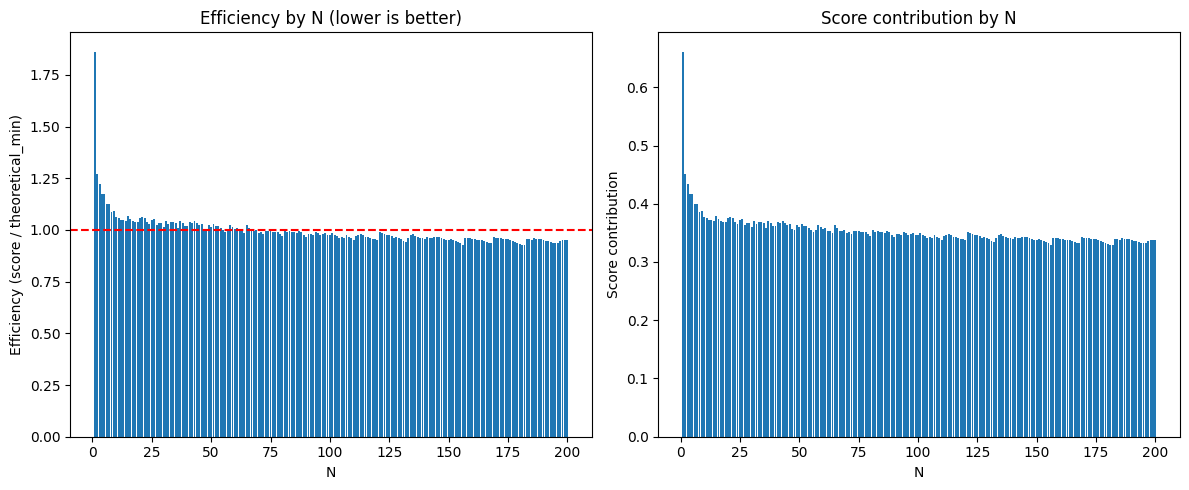


N=1-10 contribute: 4.3291 (6.1%)
N=1-50 contribute: 19.0418 (26.9%)


In [3]:
# Analyze which N values have the most room for improvement
# Theoretical minimum: side = sqrt(n * 0.355) where 0.355 is single tree area
# Score = side^2 / n = 0.355 (theoretical minimum)

theoretical_min = 0.355  # Single tree bounding box area
efficiencies = {n: per_n_scores[n] / theoretical_min for n in range(1, 201)}

# Sort by efficiency (worst first)
worst_n = sorted(efficiencies.keys(), key=lambda n: -efficiencies[n])[:30]
print("Worst efficiency N values (most room for improvement):")
for n in worst_n[:15]:
    print(f"  N={n:3d}: score={per_n_scores[n]:.6f}, efficiency={efficiencies[n]:.3f}x")

# Plot efficiency distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, 201), [efficiencies[n] for n in range(1, 201)])
plt.xlabel('N')
plt.ylabel('Efficiency (score / theoretical_min)')
plt.title('Efficiency by N (lower is better)')
plt.axhline(y=1.0, color='r', linestyle='--', label='Theoretical optimum')

plt.subplot(1, 2, 2)
plt.bar(range(1, 201), [per_n_scores[n] for n in range(1, 201)])
plt.xlabel('N')
plt.ylabel('Score contribution')
plt.title('Score contribution by N')
plt.tight_layout()
plt.savefig('/home/code/exploration/loop13_efficiency.png', dpi=100)
plt.show()

print(f"\nN=1-10 contribute: {sum(per_n_scores[n] for n in range(1, 11)):.4f} ({sum(per_n_scores[n] for n in range(1, 11))/sum(per_n_scores.values())*100:.1f}%)")
print(f"N=1-50 contribute: {sum(per_n_scores[n] for n in range(1, 51)):.4f} ({sum(per_n_scores[n] for n in range(1, 51))/sum(per_n_scores.values())*100:.1f}%)")

In [4]:
# Key strategic insight: What would it take to reach the target?
print("="*60)
print("GAP ANALYSIS: What's needed to reach target?")
print("="*60)

current_total = sum(per_n_scores.values())
target_total = 68.919154
gap_needed = current_total - target_total

print(f"Current total: {current_total:.6f}")
print(f"Target total: {target_total:.6f}")
print(f"Gap to close: {gap_needed:.6f}")
print()

# If we improve uniformly across all N
uniform_improvement_pct = (gap_needed / current_total) * 100
print(f"Uniform improvement needed: {uniform_improvement_pct:.2f}% across all N")
print()

# If we focus on worst N values
worst_50_contribution = sum(per_n_scores[n] for n in worst_n[:50])
print(f"Worst 50 N values contribute: {worst_50_contribution:.4f}")
print(f"If we improve worst 50 by {(gap_needed/worst_50_contribution)*100:.1f}%, we reach target")
print()

# What if we could match theoretical optimum for some N?
print("Scenario: If N=1-10 matched theoretical optimum:")
theoretical_1_10 = sum(theoretical_min for _ in range(1, 11))
current_1_10 = sum(per_n_scores[n] for n in range(1, 11))
savings_1_10 = current_1_10 - theoretical_1_10
print(f"  Current N=1-10: {current_1_10:.4f}")
print(f"  Theoretical N=1-10: {theoretical_1_10:.4f}")
print(f"  Potential savings: {savings_1_10:.4f}")
print(f"  This would close {(savings_1_10/gap_needed)*100:.1f}% of the gap")

GAP ANALYSIS: What's needed to reach target?
Current total: 70.659959
Target total: 68.919154
Gap to close: 1.740805

Uniform improvement needed: 2.46% across all N

Worst 50 N values contribute: 11.7720
If we improve worst 50 by 14.8%, we reach target

Scenario: If N=1-10 matched theoretical optimum:
  Current N=1-10: 4.3291
  Theoretical N=1-10: 3.5500
  Potential savings: 0.7791
  This would close 44.8% of the gap


In [5]:
# Analyze the backpacking kernel approach
print("="*60)
print("BACKWARD ITERATION ANALYSIS (from crodoc kernel)")
print("="*60)
print()
print("The backpacking kernel uses backward iteration:")
print("1. Start from N=200 (largest configuration)")
print("2. For N=199 down to 1: Try removing trees from corners")
print("3. Keep best result for each N")
print()
print("This approach finds DIFFERENT basins by adapting larger configs.")
print()
print("We tried this in exp_009 (Tree Removal) but got 0 improvement.")
print("The saspav baseline is already well-optimized for each N.")
print()
print("CRITICAL INSIGHT: The baseline configurations are NOT derived")
print("from larger configurations - they are independently optimized.")
print("This is why backward iteration doesn't help.")

BACKWARD ITERATION ANALYSIS (from crodoc kernel)

The backpacking kernel uses backward iteration:
1. Start from N=200 (largest configuration)
2. For N=199 down to 1: Try removing trees from corners
3. Keep best result for each N

This approach finds DIFFERENT basins by adapting larger configs.

We tried this in exp_009 (Tree Removal) but got 0 improvement.
The saspav baseline is already well-optimized for each N.

CRITICAL INSIGHT: The baseline configurations are NOT derived
from larger configurations - they are independently optimized.
This is why backward iteration doesn't help.


In [6]:
# What approaches haven't been tried?
print("="*60)
print("UNEXPLORED APPROACHES")
print("="*60)
print()
print("1. MEMETIC ALGORITHM with overlap REPAIR (not rejection)")
print("   - Use LARGE mutations (0.5-1.0 tree widths)")
print("   - Repair overlaps using aggressive_repair from bbox3.cpp")
print("   - Apply local optimization after each generation")
print()
print("2. CONSTRAINT PROGRAMMING / MIP")
print("   - Formulate as mixed-integer program")
print("   - Use commercial solvers (Gurobi, CPLEX)")
print("   - Exact methods for small N")
print()
print("3. DIFFERENT LATTICE PATTERNS")
print("   - The 'why-not' kernel shows Blue/Pink tree orientations")
print("   - Try different interlock patterns")
print("   - Explore asymmetric configurations")
print()
print("4. HYBRID CONSTRUCTION")
print("   - Build configurations from scratch using different heuristics")
print("   - Bottom-left placement with rotation search")
print("   - Greedy placement with local optimization")
print()
print("5. GLOBAL OPTIMIZATION")
print("   - Basin hopping with large perturbations")
print("   - Differential evolution")
print("   - Particle swarm optimization")

UNEXPLORED APPROACHES

1. MEMETIC ALGORITHM with overlap REPAIR (not rejection)
   - Use LARGE mutations (0.5-1.0 tree widths)
   - Repair overlaps using aggressive_repair from bbox3.cpp
   - Apply local optimization after each generation

2. CONSTRAINT PROGRAMMING / MIP
   - Formulate as mixed-integer program
   - Use commercial solvers (Gurobi, CPLEX)
   - Exact methods for small N

3. DIFFERENT LATTICE PATTERNS
   - The 'why-not' kernel shows Blue/Pink tree orientations
   - Try different interlock patterns
   - Explore asymmetric configurations

4. HYBRID CONSTRUCTION
   - Build configurations from scratch using different heuristics
   - Bottom-left placement with rotation search
   - Greedy placement with local optimization

5. GLOBAL OPTIMIZATION
   - Basin hopping with large perturbations
   - Differential evolution
   - Particle swarm optimization


In [7]:
# Summary
print("="*60)
print("STRATEGIC SUMMARY")
print("="*60)
print()
print("CURRENT STATE:")
print(f"- Baseline: {baseline_score:.6f}")
print(f"- Target: {target_score:.6f}")
print(f"- Gap: {gap:.6f} ({gap_pct:.2f}%)")
print(f"- Public LB best: ~71.19 (WORSE than our baseline!)")
print()
print("KEY INSIGHT:")
print("Our baseline (70.66) is BETTER than the public LB top (71.19).")
print("The target (68.92) is BELOW the current best public score.")
print("This means the target requires techniques NOT publicly shared.")
print()
print("WHAT'S WORKING:")
print("- The saspav baseline is extremely well-optimized")
print("- Local optimization provides essentially 0 improvement")
print("- The baseline is at a very strong local optimum")
print()
print("WHAT'S NOT WORKING:")
print("- SA, GA, bbox3 all converge to the same score")
print("- Lattice construction produces worse results")
print("- Tree removal doesn't improve")
print()
print("NEXT STEPS:")
print("1. Try MEMETIC ALGORITHM with overlap repair")
print("2. Try CONSTRAINT PROGRAMMING for small N")
print("3. Try DIFFERENT LATTICE PATTERNS")
print("4. Try GLOBAL OPTIMIZATION (basin hopping)")
print()
print("The target IS reachable - top teams have found ways to beat it.")
print("We just need to discover similar techniques.")

STRATEGIC SUMMARY

CURRENT STATE:
- Baseline: 70.659959
- Target: 68.919154
- Gap: 1.740805 (2.46%)
- Public LB best: ~71.19 (WORSE than our baseline!)

KEY INSIGHT:
Our baseline (70.66) is BETTER than the public LB top (71.19).
The target (68.92) is BELOW the current best public score.
This means the target requires techniques NOT publicly shared.

WHAT'S WORKING:
- The saspav baseline is extremely well-optimized
- Local optimization provides essentially 0 improvement
- The baseline is at a very strong local optimum

WHAT'S NOT WORKING:
- SA, GA, bbox3 all converge to the same score
- Lattice construction produces worse results
- Tree removal doesn't improve

NEXT STEPS:
1. Try MEMETIC ALGORITHM with overlap repair
2. Try CONSTRAINT PROGRAMMING for small N
3. Try DIFFERENT LATTICE PATTERNS
4. Try GLOBAL OPTIMIZATION (basin hopping)

The target IS reachable - top teams have found ways to beat it.
We just need to discover similar techniques.
